In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense , Dropout

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [212]:
import zipfile

# Path to your zip file
zip_path = "/content/archive (9).zip"
extract_path = "/content/files"  # choose where to extract

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Done! Files extracted to:", extract_path)

Done! Files extracted to: /content/files


In [213]:
data=pd.read_csv('/content/files/DailyDelhiClimateTrain.csv')

In [214]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [215]:
data.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [216]:
data2=pd.read_csv('/content/files/DailyDelhiClimateTest.csv')

In [217]:
data2.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [218]:
data2.shape

(114, 5)

In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [220]:
data = data.drop([1461])

In [221]:
data = data.drop(columns=['date'])

In [222]:
data.isnull().sum()

,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


we have to look for outliers

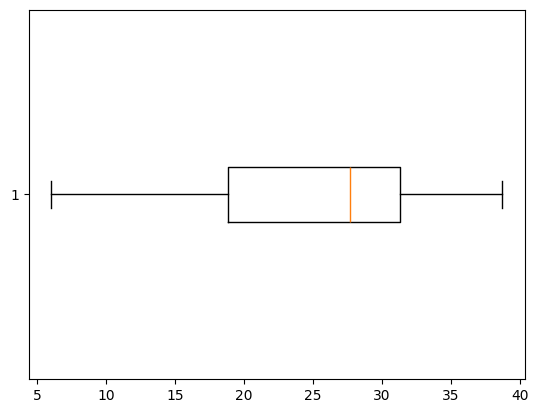

In [223]:
plt.boxplot(data['meantemp'], vert=False)
plt.show()

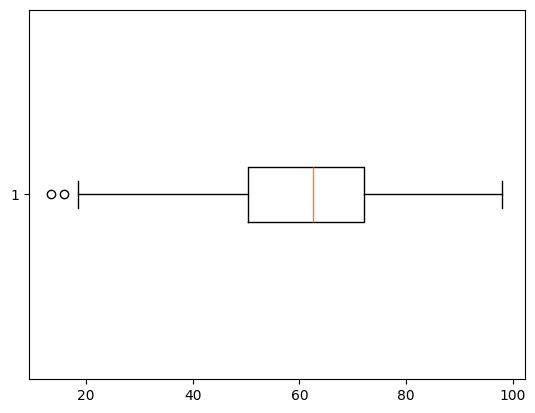

In [224]:
plt.boxplot(data['humidity'], vert=False)
plt.show()

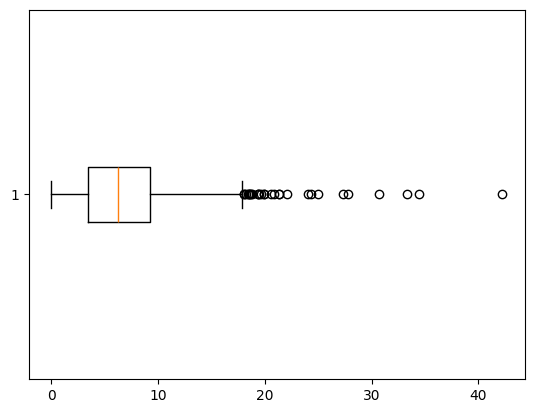

In [225]:
plt.boxplot(data['wind_speed'], vert=False)
plt.show()

In [226]:
data['wind_speed'].describe()

,wind_speed
count,1461.000000
mean,6.806865
std,4.559688
min,0.000000
25%,3.475000
50%,6.250000
75%,9.250000
max,42.220000


In [227]:
median=data.loc[data['wind_speed']<15 , 'wind_speed'].median()
data.loc[data['wind_speed']<1, 'wind_speed']=np.nan
data.loc[data['wind_speed']>15, 'wind_speed']=np.nan
data['wind_speed'].fillna(median, inplace=True)

/tmp/ipython-input-23932522.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['wind_speed'].fillna(median, inplace=True)


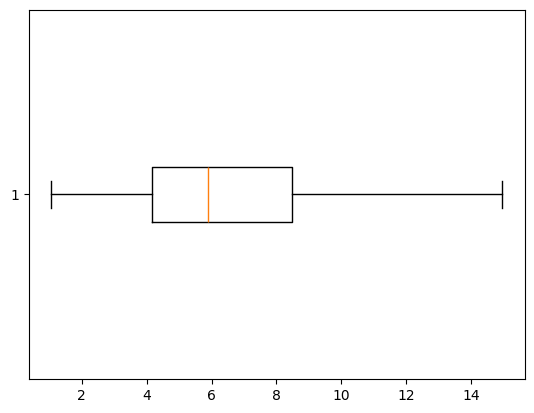

In [228]:
plt.boxplot(data['wind_speed'], vert=False)
plt.show()

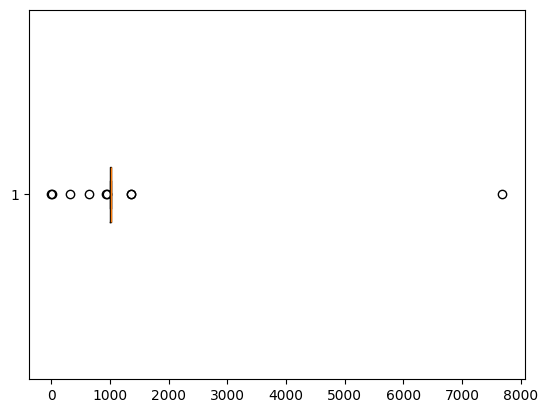

In [229]:
plt.boxplot(data['meanpressure'], vert=False)
plt.show()

In [230]:
data['meanpressure'].describe()

,meanpressure
count,1461.000000
mean,1011.101197
std,180.293335
min,-3.041667
25%,1001.571429
50%,1008.555556
75%,1014.937500
max,7679.333333


In [231]:
#atmospheric pressure lies between 760 to 1050 atm usually
median1=data.loc[data['meanpressure']<1050,'meanpressure'].median()
data.loc[data['meanpressure']<760, 'meanpressure']=np.nan
data.loc[data['meanpressure']>1050, 'meanpressure']=np.nan
data.fillna({'meanpressure':median1}, inplace=True)

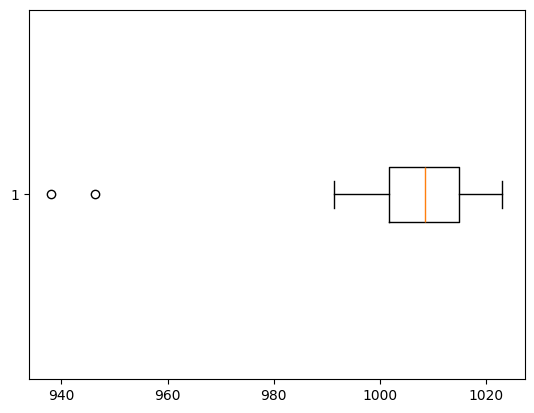

In [232]:
plt.boxplot(data['meanpressure'], vert=False)
plt.show()

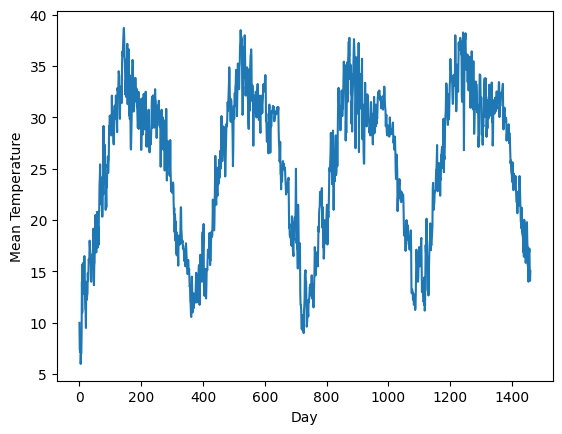

In [233]:
plt.plot(data['meantemp'])
plt.xlabel('Day')
plt.ylabel('Mean Temperature')
plt.show()

In [234]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler2=MinMaxScaler()
scaler3=MinMaxScaler()
scaler4=MinMaxScaler()

meantemp_scaled = scaler.fit_transform(data[['meantemp']])
humidity_scaled = scaler2.fit_transform(data[['humidity']])
windspeed_scaled = scaler3.fit_transform(data[['wind_speed']])
meanpressure_scaled = scaler4.fit_transform(data[['meanpressure']])

In [235]:
X_scaled = np.concatenate((meantemp_scaled, humidity_scaled, windspeed_scaled, meanpressure_scaled), axis=1)
X_scaled.shape

(1461, 4)

In [236]:
x=[]
for i in range(X_scaled.shape[0]-30):
  row=X_scaled[i:i+31]
  x.append(row)

In [237]:
len(x)

1431

In [238]:
x=np.array(x)

In [239]:
x.shape

(1431, 31, 4)

In [240]:
X_train=x[:,:-1]

In [241]:
X_train.shape

(1431, 30, 4)

In [242]:
Y_train=x[:,-1,0]

In [243]:
Y_train.shape

(1431,)

In [244]:
X_train.shape ,Y_train.shape, X_train.ndim, Y_train.ndim

((1431, 30, 4), (1431,), 3, 1)

In [261]:
model=Sequential()
model.add(LSTM(100,input_shape=(30,4),return_sequences=True))
model.add(LSTM(100 ,return_sequences=True, recurrent_dropout=0.2))
model.add(LSTM(100,return_sequences=True, recurrent_dropout=0.2))
model.add(LSTM(100,return_sequences=False, recurrent_dropout=0.2))
model.add(Dense(1,activation='linear'))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 30, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [262]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, Y_train, batch_size=32,epochs=50)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - loss: 0.0967 - mae: 0.2226
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - loss: 0.0074 - mae: 0.0681
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - loss: 0.0074 - mae: 0.0683
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - loss: 0.0068 - mae: 0.0648
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - loss: 0.0065 - mae: 0.0637
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 248ms/step - loss: 0.0062 - mae: 0.0631
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - loss: 0.0063 - mae: 0.0641
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - loss: 0.0056 - mae: 0.0586
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - loss: 0.0054 - mae: 0.0575
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - loss: 0.0057 - mae: 0.0587
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - loss: 0.0058 - mae: 0.0607
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - loss: 0.0052 - mae: 0.0572
Epoch 13/50
4

In [263]:
data2.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [264]:
#last 30 rows of training data and the entire test data
test_data=pd.DataFrame()
test_data=pd.concat([data.tail(30),data2], ignore_index=True)
test_data=test_data.drop(columns=['date'])

In [265]:
test_data.head()

,meantemp,humidity,wind_speed,meanpressure
0,19.208333,75.875000,4.945833,1017.750000
1,21.208333,52.166667,5.866667,1019.333333
2,18.900000,55.250000,5.666667,1019.700000
3,18.636364,56.590909,4.952381,1017.045455
4,18.538462,69.923077,2.503846,1017.961538


In [266]:
test_data.shape

(144, 4)

In [267]:
meantemp_scaled1 = scaler.transform(test_data[['meantemp']])
humidity_scaled1 = scaler2.transform(test_data[['humidity']])
windspeed_scaled1 = scaler3.transform(test_data[['wind_speed']])
meanpressure_scaled1 = scaler4.transform(test_data[['meanpressure']])

In [268]:
X_scaled_test = np.concatenate((meantemp_scaled1, humidity_scaled1, windspeed_scaled1, meanpressure_scaled1), axis=1)


In [269]:
#creating batches of 30 days for testing data
x_test=[]
for i in range(X_scaled_test.shape[0]-30):
  row=X_scaled_test[i:i+31]
  x_test.append(row)

In [270]:
x_test=np.array(x_test)

In [271]:
x_test.shape

(114, 31, 4)

In [272]:
X_test=x_test[:,:-1]
Y_test=x_test[:,-1,0]
X_test.shape ,Y_test.shape, X_test.ndim, Y_test.ndim

((114, 30, 4), (114,), 3, 1)

In [273]:
predictions=model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step


In [274]:
predictions.shape

(114, 1)

In [275]:
predictions=scaler.inverse_transform(predictions)
Y_test=Y_test.reshape(-1,1)
Y_test=scaler.inverse_transform(Y_test)

In [276]:
r2_score=r2_score(Y_test,predictions)
r2_score

0.9205006750192376

In [277]:
mae=mean_absolute_error(Y_test,predictions)
mae

1.4574282097286975

In [278]:
mse=mean_squared_error(Y_test,predictions)
np.sqrt(mse)

np.float64(1.7853794779751353)

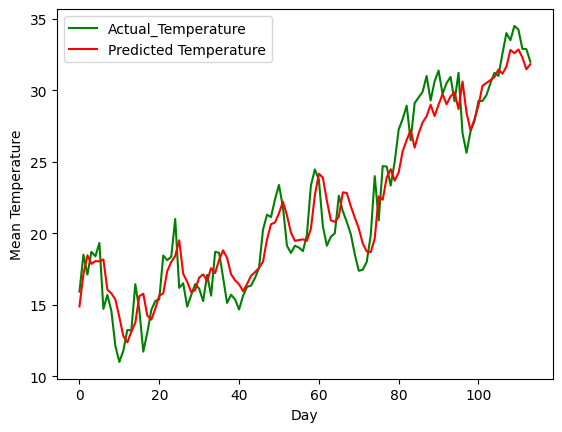

In [279]:
plt.plot(Y_test, label='Actual_Temperature', color='green')
plt.plot(predictions, label='Predicted Temperature', color='red')
plt.legend(loc='best')
plt.xlabel('Day')
plt.ylabel('Mean Temperature')
plt.show()

In [280]:
model.save('delhi_temperature_model.keras')